In [1]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds
import pathlib
import keras
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import Reshape
from keras.layers import MaxPool2D
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import Dense
from keras.layers import Rescaling
from keras.preprocessing.image import load_img,img_to_array,ImageDataGenerator

2023-10-13 10:33:44.728996: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-13 10:33:44.760692: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-13 10:33:44.761616: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-13 10:33:45.395897: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/share/Machine Learning/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
os.environ['XLA_FLAGS'] = "--xla_gpu_cuda_data_dir=/usr/lib/cuda"
os.environ['TF_GPU_ALLOCATOR'] = "cuda_malloc_async"
os.system('echo $XLA_FLAGS')
os.system('echo $TF_GPU_ALLOCATOR')

--xla_gpu_cuda_data_dir=/usr/lib/cuda
cuda_malloc_async


0

In [3]:
print(tf.__version__)

2.13.0


In [4]:
data_dir = pathlib.Path('./Datasets/lung/').with_suffix('')
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

681


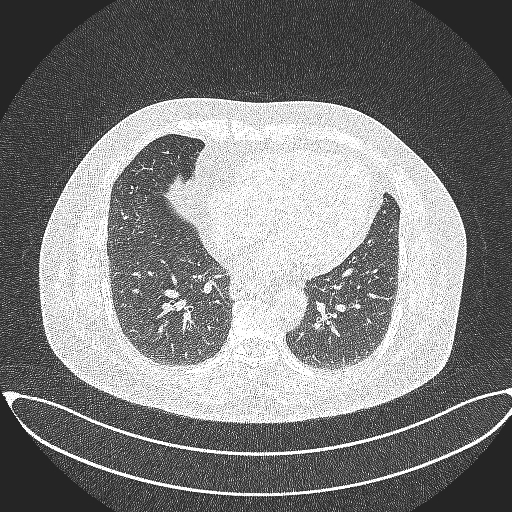

In [5]:
bengin=list(data_dir.glob('Bengin cases/*'))
PIL.Image.open(str(bengin[1]))

In [6]:
# train_ds=ImageDataGenerator(zoom_range=0.2,shear_range=0.2,rescale=1/255,horizontal_flip=True).flow_from_directory(directory=path,target_size=(512,512),batch_size=)
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.4,
  subset="training",
  seed=123,
  image_size=(512, 512),
  batch_size=32)

Found 681 files belonging to 2 classes.
Using 409 files for training.


In [7]:
print(type(train_ds))

<class 'tensorflow.python.data.ops.batch_op._BatchDataset'>


In [8]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.4,
  subset="validation",
  seed=123,
  image_size=(512, 512),
  batch_size=32)

Found 681 files belonging to 2 classes.
Using 272 files for validation.


In [9]:
class_names_ = train_ds.class_names # type: ignore
print(class_names_)

['Bengin cases', 'Malignant cases']


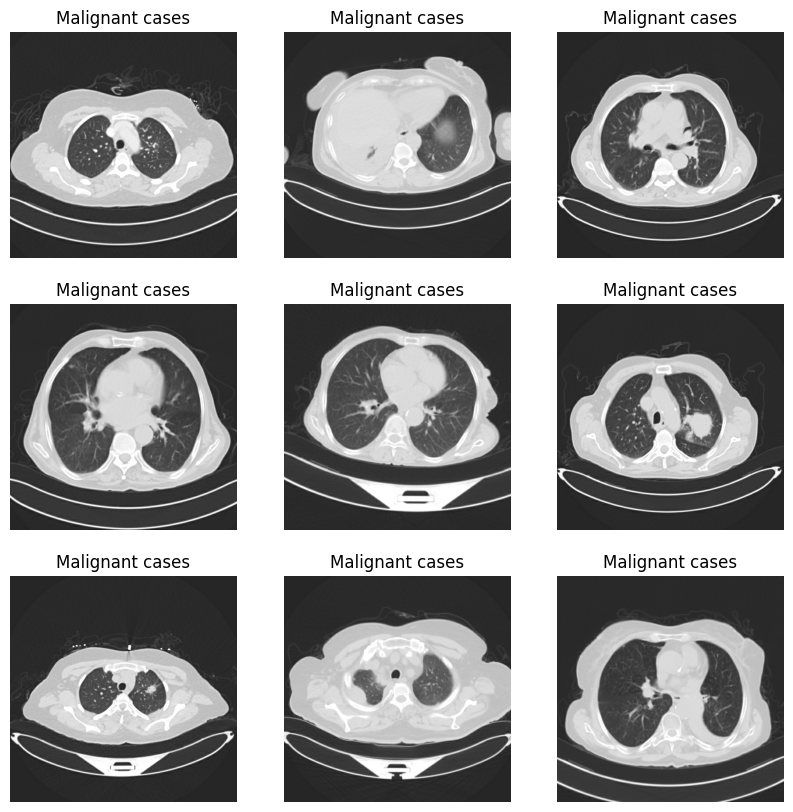

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1): # type: ignore
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names_[labels[i]])
    plt.axis("off")

In [11]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 512, 512, 3)
(32,)


In [12]:
num_classes = 2

# model = tf.keras.Sequential([
#   tf.keras.layers.Rescaling(1./255),
#   tf.keras.layers.Conv2D(4, 3, activation='relu'),
#   tf.keras.layers.MaxPooling2D(),
#   tf.keras.layers.Conv2D(4, 3, activation='relu'),
#   tf.keras.layers.MaxPooling2D(),
#   tf.keras.layers.Conv2D(4, 3, activation='relu'),
#   tf.keras.layers.MaxPooling2D(),
#   tf.keras.layers.Flatten(),
#   tf.keras.layers.Dense(32, activation='relu'),
#   tf.keras.layers.Dense(num_classes)
# ])
model=Sequential()
model.add(Conv2D(filters= 8,kernel_size=(3,3),activation='sigmoid',input_shape=(512,512,3),padding='same'))
model.add(Conv2D(filters= 24,kernel_size=(3,3),activation='sigmoid'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters= 72,kernel_size=(3,3),activation='sigmoid'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters=128,kernel_size=(3,3),activation='sigmoid'))
model.add(MaxPool2D(pool_size=(2,2)))
# model.add(Dropout(rate=0.25))
model.add(Flatten())
model.add(Dense(units=64,activation='sigmoid'))
# model.add(Dropout(rate=0.25))
# model.add(Dense(3,activation='softmax'))
model.add(Dense(1,activation='sigmoid'))
model.summary()
# model=Sequential()
# model.add(Conv2D(32,(3,3),activation='relu',input_shape=(512,512,3)))
# model.add(MaxPool2D(2,2))
# model.add(Flatten())
# model.add(Dense(100,activation='relu'))
# model.add(Dense(10,activation='softmax'))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 512, 512, 8)       224       
                                                                 
 conv2d_1 (Conv2D)           (None, 510, 510, 24)      1752      
                                                                 
 max_pooling2d (MaxPooling2  (None, 255, 255, 24)      0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 253, 253, 72)      15624     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 126, 126, 72)      0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 124, 124, 128)     8

In [13]:
from keras.callbacks import ModelCheckpoint,EarlyStopping
es=EarlyStopping(monitor="val_accuracy",min_delta=0.01,patience=4,verbose=1,mode='auto')
mc=ModelCheckpoint(monitor="val_accuracy",filepath="./bestmodel.h5",verbose=0,save_best_only=True,mode='auto')
cd=[es,mc]

In [14]:
AUTOTUNE = tf.data.AUTOTUNE
classes=list(train_ds.class_names) 
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE) # type: ignore
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE) # type: ignore

In [15]:
import keras.backend as K
def my_fn(y_true,y_pred):
    with open('test.txt','w+') as f:
        f.write(str(type(y_true)))
        f.writelines(":"+str(y_true))
        f.writelines(str(K.eval(y_true)))
        f.write("\n"+str(type(y_pred)))
        f.writelines(":"+str(y_pred))
        f.writelines(str(K.eval(y_pred)))
    return y_true
def my_fn1(y_true,y_pred):
    return y_pred

def specificity(y_true, y_pred):

    TN = np.logical_and(K.eval(y_true) == 0, K.eval(y_pred) == 0)
    FP = np.logical_and(K.eval(y_true) == 0, K.eval(y_pred) == 1)

    # as Keras Tensors
    TN = K.sum(K.variable(TN))
    FP = K.sum(K.variable(FP))

    specificity = TN / (TN + FP + K.epsilon())
    return specificity

In [16]:

# from tensorflow.keras.optomize import
model.compile(
  optimizer='sgd',
  # optimizer=SGD(learning_rate=1e-4, momentum=0.9),
  loss=keras.losses.BinaryCrossentropy(from_logits=True),
  # loss='categorical_crossentropy',
  metrics=['accuracy',
                      tf.keras.metrics.TruePositives(),
                      tf.keras.metrics.TrueNegatives(),
                      tf.keras.metrics.FalsePositives(),
                      tf.keras.metrics.FalseNegatives()])

# model.compile(
#   optimizer='adam',
#   # optimizer=SGD(learning_rate=1e-4, momentum=0.9),
#   loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
#   # loss='categorical_crossentropy',
#   metrics=['accuracy'])
# print(tf.keras.metrics.SensitivityAtSpecificity(0.5, class_id=None, name=None, dtype=None))
# m = tf.keras.metrics.SensitivityAtSpecificity(
#         .4, num_thresholds=200)
# # m.update_state([0, 0, 1, 1], [0, 0.5, 0.3, 0.9])
# print('Result with num_thresholds = %d: %.1f' %(200, m.result().numpy()))

In [17]:
model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=10,
  callbacks=cd
)
# model.summary()

Epoch 1/10


/home/share/Machine Learning/lib/python3.10/site-packages/keras/src/backend.py:5805: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


13/13 [==============================] - ETA: 0s - loss: 0.7098 - accuracy: 0.7751 - true_positives: 311.0000 - true_negatives: 6.0000 - false_positives: 66.0000 - false_negatives: 26.0000

/home/share/Machine Learning/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


13/13 [==============================] - 61s 5s/step - loss: 0.7098 - accuracy: 0.7751 - true_positives: 311.0000 - true_negatives: 6.0000 - false_positives: 66.0000 - false_negatives: 26.0000 - val_loss: 0.6361 - val_accuracy: 0.8235 - val_true_positives: 224.0000 - val_true_negatives: 0.0000e+00 - val_false_positives: 48.0000 - val_false_negatives: 0.0000e+00
Epoch 2/10
13/13 [==============================] - 58s 4s/step - loss: 0.5877 - accuracy: 0.8240 - true_positives: 337.0000 - true_negatives: 0.0000e+00 - false_positives: 72.0000 - false_negatives: 0.0000e+00 - val_loss: 0.5511 - val_accuracy: 0.8235 - val_true_positives: 224.0000 - val_true_negatives: 0.0000e+00 - val_false_positives: 48.0000 - val_false_negatives: 0.0000e+00
Epoch 3/10
13/13 [==============================] - 58s 4s/step - loss: 0.5292 - accuracy: 0.8240 - true_positives: 337.0000 - true_negatives: 0.0000e+00 - false_positives: 72.0000 - false_negatives: 0.0000e+00 - val_loss: 0.5104 - val_accuracy: 0.8235 -

In [21]:
from keras.preprocessing.image import load_img,img_to_array
path="Datasets/lung/Malignant cases/Malignant case (561).jpg"
img=load_img(path,target_size=(512,512))
arr=img_to_array(img)
# arr.shape
arr=np.expand_dims(arr,axis=0)
pred=model.predict(arr)
pred_1=list(pred[0])
print(pred_1)
ans=list(classes)
print(ans)
print(ans[pred_1.index(max(pred_1))])

1/1 [==============================] - 0s 48ms/step
[0.8674739]
['Bengin cases', 'Malignant cases']
Bengin cases
